In [1]:
# %cd "C:\Users\user\Documents\UST\BDT\MSBD5005\project\data\"

C:\Users\user\Documents\UST\BDT\MSBD5005\project\data


In [1]:
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip install snscrape
!pip install wheel
!pip install --upgrade nbformat
!pip install plotly
# !pip install flair

  Cloning https://github.com/JustAnotherArchivist/snscrape.git to c:\users\lbaster\appdata\local\temp\pip-req-build-qrhyj_ov
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit 3dd9c28e31b8babeb2a187fbae994d9717ded168
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


  Running command git clone -q https://github.com/JustAnotherArchivist/snscrape.git 'C:\Users\lbaster\AppData\Local\Temp\pip-req-build-qrhyj_ov'


In [2]:
import pandas as pd
import numpy as np
import re
import pickle
import snscrape
import math
import plotly.express as px
import plotly.graph_objects as go
# from flair.models import TextClassifier
# from flair.data import Sentence
import pickle
import datetime
from datetime import date, timedelta

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

C:\Users\lbaster\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Create sentiment column for verified tweets

In [4]:
# file = './daily/tweet_verified_221130-230418.pkl'

# # Load the pre-trained sentiment classifier
# classifier = TextClassifier.load('en-sentiment')

# def get_sentiment(sentence):
#     sentence = Sentence(sentence)
#     classifier.predict(sentence)
#     return sentence.labels[0].value

# file_location = file
# with open(file_location, 'rb') as f:
#     tweets_dict = pickle.load(f)

# for i, k in enumerate(tweets_dict):
#     tweets_dict[k].sentiment = get_sentiment(tweets_dict[k].rawContent)
#     if (i + 1) % 500 == 0:
#         print(f'{i + 1} records processed')

# with open(re.sub('.pkl$', '_with_sentiment.pkl', file_location), 'wb') as f:
#     print('Saving...')
#     pickle.dump(tweets_dict, f)

## Read data

In [3]:
# file = './daily/tweet_verified_221130-230418_with_sentiment.pkl'
file = 'data/tweet_verified_221130-230418_with_sentiment.pkl'

with open(file, 'rb') as f:
    tweets_dict = pickle.load(f)

In [4]:
# remove occurance of r in s, mainly for removing '\n'
def removeAll(s: str, r: str) -> str:
    while r in s:
        s = s.replace(r, ' ')
    return s

In [5]:
arr = []
df_column = ['tid', 'rawContent', 'renderedContent', 'datetime', 'date', 'scrapDate', 'retweetCount', 'viewCount', 'likeCount', 'sentiment']

for tid, tweet in tweets_dict.items():
    rawContent = removeAll(tweet.rawContent, '\n')
    renderedContent = removeAll(tweet.renderedContent, '\n')
    _datetime = tweet.date
    _date = _datetime.date()
    scrapDate = datetime.date(2023, 4, 18)
    retweetCount = tweet.retweetCount
    viewCount = tweet.viewCount if tweet.viewCount else 0
    likeCount = tweet.likeCount if tweet.likeCount else 0
    sentiment = tweet.sentiment
    arr.append((tid, rawContent, renderedContent, _datetime, _date, scrapDate, retweetCount, viewCount, likeCount, sentiment))

df = pd.DataFrame(arr, columns=df_column)

# remove tweets that are too long ago
target_date = datetime.date.fromisoformat('2023-03-25')
df = df[df['date'] > target_date]
print(len(df))

13847


In [6]:
# select tweets with top n tweet with certain attribute everyday

topk = 10
topAttribute = 'viewCount'
df1 = df.groupby(by=['date']).apply(lambda x: x.nlargest(topk ,[topAttribute])).reset_index(drop=True)
print(len(df1))

240


In [7]:
# use tid as key to create attribute dictionary

tid_list = list(df1['tid'])
rawContent_list = list(df1['rawContent'])
renderedContent_list = list(df1['renderedContent'])
sentiment_list = list(df1['sentiment'])

rawContent_dict = {tid_list[i]: rawContent_list[i] for i in range(len(tid_list))}
renderedContent_dict = {tid_list[i]: renderedContent_list[i] for i in range(len(tid_list))}
sentiment_dict = {tid_list[i]: sentiment_list[i] for i in range(len(tid_list))}

In [8]:
# use tid to search for tweets in pkl files scraped everyday, to get view, like and retweet count at previous dates

tid_list = list(df1['tid'])

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = datetime.date(2023, 3, 28)
end_date = datetime.date(2023, 4, 19)
# end_date = datetime.date(2023, 3, 30)

date_ranges = daterange(start_date, end_date)

df_column = ['tid', 'rawContent', 'renderedContent', 'datetime', 'date', 'scrapDate', 'retweetCount', 'viewCount', 'likeCount', 'sentiment']
df2 = df1.copy(deep=True)

for dateobj in date_ranges:
    datestr = dateobj.strftime('%y%m%d')
    # file = f'./daily/tweet_verified_221130-{datestr}.pkl'
    file = f'data/tweet_verified_221130-{datestr}.pkl'

    with open(file, 'rb') as f:
        tweets_dict1 = pickle.load(f)

    arr = []
    
    for tid, tweet in tweets_dict1.items():
        if tid in tid_list:
            rawContent = rawContent_dict[tid]
            renderedContent = renderedContent_dict[tid]
            _datetime = tweet.date
            _date = _datetime.date()
            scrapDate = dateobj
            retweetCount = tweet.retweetCount
            viewCount = tweet.viewCount if tweet.viewCount else 0
            likeCount = tweet.likeCount if tweet.likeCount else 0
            sentiment = sentiment_dict[tid]
            arr.append((tid, rawContent, renderedContent, _datetime, _date, scrapDate, retweetCount, viewCount, likeCount, sentiment))

    df2 = pd.concat([df2, pd.DataFrame(arr, columns=df_column)])
    
print(len(df2))


3001


In [9]:
df2.head()

,tid,rawContent,renderedContent,datetime,date,scrapDate,retweetCount,viewCount,likeCount,sentiment
0,1640054386327191552,"If you’re a frequent user of ChatGPT, what are you using it for?","If you’re a frequent user of ChatGPT, what are you using it for?",2023-03-26 18:13:31+00:00,2023-03-26,2023-04-18,423,1438022,4121,POSITIVE
1,1640089361734684673,Bill Gates said this week ChatGPT and AI are as revolutionary as: -the microprocessor -the personal computer -the Internet -and the mobile phone His current views were shaped during a dinner at his home last September. Here’s more on the story 🧵… https://t.co/yImFeH3A0J,Bill Gates said this week ChatGPT and AI are as revolutionary as: -the microprocessor -the personal computer -the Internet -and the mobile phone His current views were shaped during a dinner at his home last September. Here’s more on the story 🧵… https://t.co/yImFeH3A0J,2023-03-26 20:32:29+00:00,2023-03-26,2023-04-18,392,1113249,2963,POSITIVE
2,1640016533350150146,"I feel like I should be ashamed for using ChatGPT, but I'm not sure why. It isn't good at anything except getting me started, but that's, like, the thing I am worst at.","I feel like I should be ashamed for using ChatGPT, but I'm not sure why. It isn't good at anything except getting me started, but that's, like, the thing I am worst at.",2023-03-26 15:43:06+00:00,2023-03-26,2023-04-18,168,560110,8265,NEGATIVE
3,1640095238604861442,"I asked ChatGPT for a ""slogan for pelicans"" and the first suggestion was ""soaring high and diving deep"" which is the EXACT vibe of a podcast series I want to do.","I asked ChatGPT for a ""slogan for pelicans"" and the first suggestion was ""soaring high and diving deep"" which is the EXACT vibe of a podcast series I want to do.",2023-03-26 20:55:51+00:00,2023-03-26,2023-04-18,89,326737,11441,POSITIVE
4,1640069366514606080,"Amazing thread. Reports of real-world utility, even anecdotal, are more informative to me than benchmarks. But there's a flip side. How many people put their symptoms into ChatGPT and got wrong answers, which they trusted over doctors? There won't be viral threads about those.","Amazing thread. Reports of real-world utility, even anecdotal, are more informative to me than benchmarks. But there's a flip side. How many people put their symptoms into ChatGPT and got wrong answers, which they trusted over doctors? There won't be viral threads about those.",2023-03-26 19:13:02+00:00,2023-03-26,2023-04-18,131,238854,838,POSITIVE


In [10]:
df2.groupby('date').count()

,tid,rawContent,renderedContent,datetime,scrapDate,retweetCount,viewCount,likeCount,sentiment
date,,,,,,,,,
2023-03-26,230,230,230,230,230,230,230,230,230
2023-03-27,230,230,230,230,230,230,230,230,230
2023-03-28,220,220,220,220,220,220,220,220,220
2023-03-29,210,210,210,210,210,210,210,210,210
2023-03-30,201,201,201,201,201,201,201,201,201
2023-03-31,189,189,189,189,189,189,189,189,189
2023-04-01,181,181,181,181,181,181,181,181,181
2023-04-02,170,170,170,170,170,170,170,170,170
2023-04-03,160,160,160,160,160,160,160,160,160


In [12]:
print(df2["sentiment"].unique())

['NEGATIVE' 'POSITIVE']


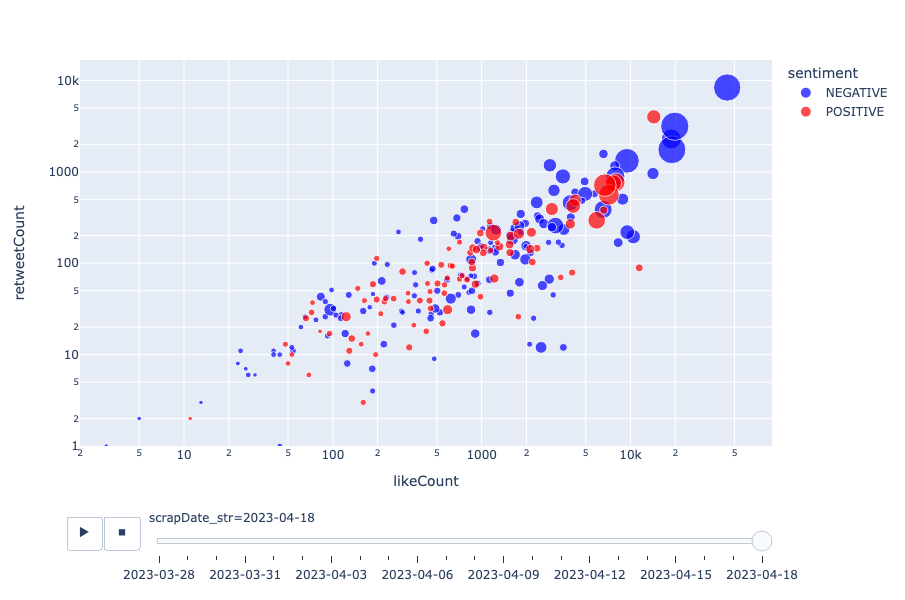

In [13]:
# import plotly.express as px

# df2 = df2.sort_values(by='scrapDate')

# x_axis = "likeCount"
# y_axis = "retweetCount"
# size = "viewCount"
# range_x = [df2[x_axis].min()+1, df2[x_axis].max()*2]
# range_y = [df2[y_axis].min()+1, df2[y_axis].max()*2]

# normalized_size = (df2[size]-df2[size].min())/(df2[size].max()-df2[size].min())*40+1

# px.scatter(df2, x=x_axis, y=y_axis, animation_frame="scrapDate", animation_group="tid",
#            log_x=True, log_y=True, range_x=range_x, range_y=range_y,
#             size=normalized_size, color="sentiment", hover_name="tid")


import plotly.express as px

df2 = df2.sort_values(by='scrapDate')

x_axis = "likeCount"
y_axis = "retweetCount"
size = "viewCount"
range_x = [df2[x_axis].min()+1, df2[x_axis].max()*2]
range_y = [df2[y_axis].min()+1, df2[y_axis].max()*2]

normalized_size = (df2[size]-df2[size].min())/(df2[size].max()-df2[size].min())*40+1

# convert the datetime.date object to a string using strftime
df2["scrapDate_str"] = df2["scrapDate"].apply(lambda x: x.strftime("%Y-%m-%d"))

fig = px.scatter(df2, x=x_axis, y=y_axis, animation_frame="scrapDate_str", animation_group="tid",
           log_x=True, log_y=True, range_x=range_x, range_y=range_y,
           size=normalized_size, color="sentiment", hover_name="tid", color_discrete_map={"POSITIVE": "red", "NEGATIVE": "blue"})

fig.update_layout(width=800, height=600)

## range slider
# fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [23]:
# create a new column that contains the length of the tweet text
df2['text_length'] = df2['renderedContent'].apply(len)

# group the tweets by ID and extract the top 5 tweets for each ID by text length
top_tweets = df2.groupby('tid').apply(lambda x: x.nlargest(5, 'text_length')).reset_index(drop=True)

# merge the top tweets with the original DataFrame
top_tweets = top_tweets.drop('text_length', axis=1)
top_tweets = top_tweets.rename(columns={'renderedContent': 'top_tweets'})
df3 = pd.merge(df2, top_tweets, on='tid')

In [26]:
df3.head()

,tid,rawContent_x,renderedContent,datetime_x,date_x,scrapDate_x,retweetCount_x,viewCount_x,likeCount_x,sentiment_x,...,top_tweets,datetime_y,date_y,scrapDate_y,retweetCount_y,viewCount_y,likeCount_y,sentiment_y,scrapDate_str_y,hotness_y
0,1645817335024869376,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE","Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,...,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,2023-04-18,5752822
1,1645817335024869376,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE","Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,...,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,2023-04-18,5752822
2,1645817335024869376,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE","Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,...,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-17,3123,5625811,19699,NEGATIVE,2023-04-17,5648633
3,1645817335024869376,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE","Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,...,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-16,3075,5596021,19599,NEGATIVE,2023-04-16,5618695
4,1645817335024869376,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE","Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-18,3154,5729830,19838,NEGATIVE,...,"Btw, ChatGPT is old news AutoGPT is the new kid on the block Read this if you want to stay ahead: https://t.co/oq6WYiIZZE",2023-04-11 15:53:25+00:00,2023-04-11,2023-04-15,2953,5485252,19286,NEGATIVE,2023-04-15,5507491
